In [1]:
%matplotlib ipympl
%load_ext autoreload
%autoreload 2
import mido
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
import midi_utils as mu
import scales

In [2]:
filename = "MIDI_Files/Never-Gonna-Give-You-Up-3.mid"
m = mido.MidiFile(filename=filename)
print(m.print_tracks())

=== Track 0
MetaMessage('track_name', name='0013GIVE', time=0)
MetaMessage('set_tempo', tempo=300000, time=0)
MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0)
MetaMessage('text', text='0013GIVE\x00\x00', time=0)
Message('sysex', data=(126, 127, 9, 1), time=10)
Message('sysex', data=(65, 16, 66, 18, 64, 0, 127, 0, 65), time=14)
Message('sysex', data=(65, 16, 66, 18, 64, 1, 16, 2, 0, 1, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 23), time=24)
Message('sysex', data=(65, 16, 66, 18, 64, 1, 51, 90, 50), time=24)
Message('sysex', data=(65, 16, 66, 18, 64, 1, 58, 90, 43), time=40)
Message('control_change', channel=1, control=121, value=0, time=212)
Message('control_change', channel=2, control=121, value=0, time=4)
Message('control_change', channel=3, control=121, value=0, time=4)
Message('control_change', channel=4, control=121, value=0, time=4)
Message('control_change', channel=5, control=121, value=0, time=4)
Message('control_

Message('note_on', channel=3, note=60, velocity=92, time=0)
Message('note_on', channel=4, note=68, velocity=87, time=0)
Message('note_on', channel=4, note=63, velocity=84, time=0)
Message('note_on', channel=4, note=65, velocity=86, time=0)
Message('note_on', channel=4, note=60, velocity=85, time=0)
Message('note_on', channel=15, note=63, velocity=119, time=0)
Message('note_off', channel=9, note=36, velocity=105, time=4)
Message('note_off', channel=9, note=42, velocity=83, time=0)
Message('note_off', channel=15, note=63, velocity=119, time=84)
Message('note_off', channel=2, note=34, velocity=111, time=0)
Message('note_on', channel=9, note=46, velocity=91, time=104)
Message('note_on', channel=2, note=32, velocity=107, time=0)
Message('note_on', channel=15, note=63, velocity=119, time=0)
Message('note_off', channel=9, note=46, velocity=91, time=4)
Message('note_off', channel=15, note=63, velocity=119, time=84)
Message('note_off', channel=2, note=32, velocity=107, time=0)
Message('note_on'

Message('note_on', channel=9, note=39, velocity=86, time=0)
Message('note_off', channel=9, note=39, velocity=86, time=4)
Message('note_off', channel=9, note=45, velocity=84, time=0)
Message('note_off', channel=9, note=36, velocity=104, time=0)
Message('note_off', channel=9, note=42, velocity=80, time=0)
Message('note_on', channel=9, note=45, velocity=87, time=92)
Message('note_on', channel=9, note=39, velocity=87, time=0)
Message('note_off', channel=9, note=39, velocity=87, time=4)
Message('note_off', channel=9, note=45, velocity=87, time=0)
Message('note_on', channel=9, note=46, velocity=92, time=92)
Message('note_on', channel=9, note=43, velocity=80, time=0)
Message('note_on', channel=2, note=32, velocity=106, time=0)
Message('note_on', channel=7, note=73, velocity=83, time=0)
Message('note_on', channel=7, note=85, velocity=110, time=0)
Message('note_off', channel=9, note=43, velocity=80, time=4)
Message('note_off', channel=9, note=46, velocity=92, time=0)
Message('note_off', channel

Message('note_off', channel=9, note=46, velocity=87, time=4)
Message('note_off', channel=2, note=32, velocity=109, time=84)
Message('note_off', channel=8, note=87, velocity=94, time=56)
Message('note_off', channel=15, note=63, velocity=123, time=16)
Message('note_off', channel=13, note=72, velocity=88, time=24)
Message('note_off', channel=13, note=63, velocity=84, time=0)
Message('note_off', channel=13, note=68, velocity=84, time=0)
Message('note_on', channel=9, note=42, velocity=83, time=8)
Message('note_on', channel=9, note=38, velocity=105, time=0)
Message('note_on', channel=9, note=39, velocity=86, time=0)
Message('note_on', channel=8, note=80, velocity=94, time=0)
Message('note_on', channel=15, note=56, velocity=122, time=0)
Message('note_off', channel=9, note=39, velocity=86, time=4)
Message('note_off', channel=9, note=38, velocity=105, time=0)
Message('note_off', channel=9, note=42, velocity=83, time=0)
Message('note_off', channel=15, note=56, velocity=122, time=84)
Message('not

Message('note_on', channel=9, note=42, velocity=81, time=104)
Message('note_on', channel=9, note=36, velocity=109, time=0)
Message('note_on', channel=9, note=39, velocity=81, time=0)
Message('note_off', channel=9, note=39, velocity=81, time=4)
Message('note_off', channel=9, note=36, velocity=109, time=0)
Message('note_off', channel=9, note=42, velocity=81, time=0)
Message('note_on', channel=9, note=39, velocity=80, time=92)
Message('note_off', channel=9, note=39, velocity=80, time=4)
Message('note_on', channel=9, note=46, velocity=92, time=92)
Message('note_on', channel=2, note=32, velocity=110, time=0)
Message('note_on', channel=7, note=73, velocity=82, time=0)
Message('note_on', channel=7, note=85, velocity=109, time=0)
Message('note_off', channel=9, note=46, velocity=92, time=4)
Message('note_off', channel=7, note=85, velocity=109, time=60)
Message('note_off', channel=7, note=73, velocity=82, time=0)
Message('note_off', channel=2, note=32, velocity=110, time=24)
Message('note_on', c

Message('note_on', channel=9, note=46, velocity=90, time=8)
Message('note_on', channel=15, note=56, velocity=124, time=0)
Message('note_off', channel=9, note=46, velocity=90, time=4)
Message('note_on', channel=9, note=42, velocity=84, time=188)
Message('note_on', channel=9, note=38, velocity=108, time=0)
Message('note_on', channel=9, note=39, velocity=84, time=0)
Message('note_off', channel=9, note=39, velocity=84, time=4)
Message('note_off', channel=9, note=38, velocity=108, time=0)
Message('note_off', channel=9, note=42, velocity=84, time=0)
Message('note_on', channel=9, note=46, velocity=88, time=188)
Message('note_off', channel=9, note=46, velocity=88, time=4)
Message('note_off', channel=15, note=56, velocity=124, time=60)
Message('note_on', channel=9, note=42, velocity=81, time=128)
Message('note_on', channel=9, note=36, velocity=109, time=0)
Message('note_off', channel=9, note=36, velocity=109, time=4)
Message('note_off', channel=9, note=42, velocity=81, time=0)
Message('note_on'

Message('note_off', channel=7, note=68, velocity=81, time=0)
Message('note_off', channel=2, note=32, velocity=106, time=24)
Message('note_on', channel=7, note=68, velocity=81, time=8)
Message('note_on', channel=7, note=80, velocity=110, time=0)
Message('note_on', channel=7, note=56, velocity=83, time=0)
Message('note_off', channel=7, note=56, velocity=83, time=64)
Message('note_off', channel=7, note=80, velocity=110, time=0)
Message('note_off', channel=7, note=68, velocity=81, time=0)
Message('note_off', channel=15, note=61, velocity=124, time=0)
Message('note_on', channel=9, note=42, velocity=83, time=32)
Message('note_on', channel=9, note=38, velocity=102, time=0)
Message('note_on', channel=9, note=39, velocity=86, time=0)
Message('note_on', channel=2, note=32, velocity=106, time=0)
Message('note_on', channel=8, note=92, velocity=98, time=0)
Message('note_on', channel=15, note=56, velocity=120, time=0)
Message('note_off', channel=9, note=39, velocity=86, time=4)
Message('note_off', c

Message('note_on', channel=13, note=72, velocity=87, time=0)
Message('note_on', channel=13, note=68, velocity=88, time=0)
Message('note_on', channel=15, note=60, velocity=119, time=0)
Message('note_off', channel=15, note=60, velocity=119, time=88)
Message('note_off', channel=13, note=68, velocity=88, time=0)
Message('note_off', channel=13, note=72, velocity=87, time=0)
Message('note_off', channel=13, note=63, velocity=86, time=0)
Message('note_on', channel=9, note=46, velocity=90, time=8)
Message('note_on', channel=2, note=34, velocity=109, time=0)
Message('note_on', channel=13, note=61, velocity=85, time=0)
Message('note_on', channel=13, note=70, velocity=87, time=0)
Message('note_on', channel=13, note=65, velocity=86, time=0)
Message('note_on', channel=15, note=58, velocity=122, time=0)
Message('note_off', channel=9, note=46, velocity=90, time=4)
Message('note_off', channel=2, note=34, velocity=109, time=84)
Message('note_on', channel=2, note=34, velocity=107, time=8)
Message('note_o

Message('note_off', channel=3, note=68, velocity=92, time=8)
Message('note_on', channel=9, note=45, velocity=82, time=0)
Message('note_on', channel=2, note=32, velocity=106, time=0)
Message('note_on', channel=3, note=70, velocity=90, time=0)
Message('note_off', channel=9, note=45, velocity=82, time=4)
Message('note_off', channel=2, note=32, velocity=106, time=84)
Message('note_off', channel=3, note=70, velocity=90, time=8)
Message('note_on', channel=9, note=46, velocity=89, time=0)
Message('note_on', channel=9, note=43, velocity=83, time=0)
Message('note_on', channel=3, note=73, velocity=93, time=0)
Message('note_off', channel=9, note=43, velocity=83, time=4)
Message('note_off', channel=9, note=46, velocity=89, time=0)
Message('note_off', channel=3, note=73, velocity=93, time=92)
Message('note_off', channel=3, note=58, velocity=89, time=0)
Message('note_off', channel=3, note=61, velocity=87, time=0)
Message('note_off', channel=3, note=65, velocity=86, time=0)
Message('note_on', channel

In [4]:
import pygame

pygame 2.1.2 (SDL 2.0.18, Python 3.7.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [5]:
def play_music(midi_filename):
  '''Stream music_file in a blocking manner'''
  clock = pygame.time.Clock()
  pygame.mixer.music.load(midi_filename)
  pygame.mixer.music.play()
  while pygame.mixer.music.get_busy():
    clock.tick(30) # check if playback has finished

In [6]:
# mixer config
freq = 44100  # audio CD quality
bitsize = -16   # unsigned 16 bit
channels = 2  # 1 is mono, 2 is stereo
buffer = 1024   # number of samples
pygame.mixer.init(freq, bitsize, channels, buffer)

# optional volume 0 to 1.0
pygame.mixer.music.set_volume(0.8)

# listen for interruptions
try:
  # use the midi file you just saved
  play_music(filename)
except KeyboardInterrupt:
  # if user hits Ctrl/C then exit
  # (works only in console mode)
  pygame.mixer.music.fadeout(1000)
  pygame.mixer.music.stop()
  raise SystemExit

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "<ipython-input-6-c41d3ed34bd0>", line 14, in <module>
    play_music(filename)
  File "<ipython-input-5-39d9b10b84c7>", line 7, in play_music
    clock.tick(30) # check if playback has finished
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/manon/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-c41d3ed34bd0>", line 20, in <module>
    raise SystemExit
SystemExit

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/manon/anaconda3/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/Users/manon/anaconda3/lib/python3.7/site-packages/IPython/core/ultratb.py

TypeError: object of type 'NoneType' has no len()

In [43]:

def track_to_dataframe(track, event_style=False):
    records = []
    track_name = ""
    current_time = 0
    # Event style dataframe
    if event_style:
        for x in track:
            new_dict = x.__dict__.copy()
            if not x.is_meta():
                #Swapping name for coherence
                new_dict["time_diff"] = new_dict["time"] 
                current_time += new_dict["time_diff"]
                new_dict["time"] = current_time
                new_dict["pressed"] = new_dict["type"] == "note_on"
                new_dict["released"] = new_dict["type"] == "note_off"
                records.append(new_dict)
    else:
        # Streaming style dataframe
        pressed_notes = {}
        id = 0
        for x in track:
            new_dict = x.__dict__.copy()
            if new_dict["type"] == "track_name":
                track_name = new_dict["name"]
            else:
                current_time += new_dict["time"]
                new_dict["time"] = current_time
                new_dict["time_release"] = None
                new_dict["time_duration"] = None
                new_dict["velocity_release"] = None
                if new_dict["type"] == "note_off":
                    former_pressed_note = pressed_notes[new_dict["note"]]
                    if former_pressed_note is None:
                        raise ValueError("The given track has a released note that was never pressed in the first place")
                    pressed_record = records[former_pressed_note["id"]]
                    pressed_record["time_release"] = current_time
                    pressed_record["time_duration"] = current_time - pressed_record["time"]
                    pressed_record["velocity_release"] = new_dict["velocity"]
                    pressed_notes[new_dict["note"]] = None
                elif new_dict["type"] == "note_on":
                    pressed_notes[new_dict["note"]] = {"id": id}
                    del new_dict["type"]
                    records.append(new_dict)
                    id += 1
                                        
    return pd.DataFrame(records)

pd_track = track_to_dataframe(m.tracks[1])
print(pd_track)

     time  note  velocity  channel  time_release  time_duration  \
0       0    48        71        0          4094           4094   
1       0    55        71        0          4094           4094   
2       0    60        71        0          4094           4094   
3       0    64        71        0          4094           4094   
4    4096    43        71        0          8190           4094   
5    4096    50        71        0          8190           4094   
6    4096    59        71        0          8190           4094   
7    4096    67        71        0          8190           4094   
8    8192    45        71        0         12286           4094   
9    8192    52        71        0         12286           4094   
10   8192    60        71        0         12286           4094   
11   8192    64        71        0         12286           4094   
12  12288    41        71        0         16382           4094   
13  12288    57        71        0         16382           409

c:\Users\anony\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


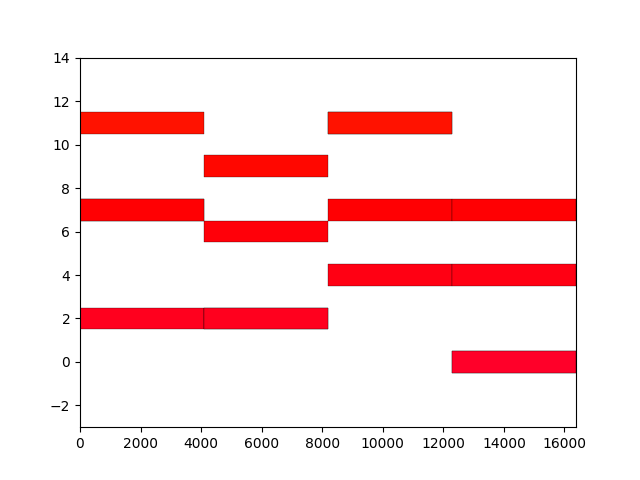

In [27]:
def plot_music(scheduled_style_df: pd.DataFrame, chroma_plot=False, ax=None, cmap=plt.get_cmap("gist_rainbow")):
    if ax is None:
        _, ax = plt.subplots()
    
    df_copy = scheduled_style_df[["time", "note", "time_duration", "time_release"]]
    if chroma_plot:
        df_copy.loc[:, "note"] = mu.to_chroma(df_copy["note"])
    for i, x in df_copy.iterrows():
        rect = patches.Rectangle((x.time, x.note - 0.5), width=x.time_duration, height=1, linewidth=0.2, edgecolor=(0,0,0), facecolor=cmap(x.note))
        ax.add_patch(rect)
    plt.xlim(0, df_copy.time_release.max())
    plt.ylim(df_copy.note.min() - 3, df_copy.note.max() + 3)

plot_music(pd_track, chroma_plot=True)


In [15]:
midi_ids = pd_track.note.to_numpy()

# Transposition:
midi_ids += 0


tonic_chroma = scales.music_to_tonic_chroma(midi_ids) # THIS FUNCTION IS BAD FOR THE MOMENT
print(tonic_chroma)
shifts = scales.music_to_chroma_shifts(midi_ids=midi_ids, tonic_chroma=tonic_chroma)
print(shifts)


[2 3 2 1 4 1 3]
7
[2 2 2 1 2 2 1]


In [44]:
# scale_selection = [scales.diatonic_scale(c) for c in range(12)] \
#                   + [scales.diatonic_scale(c, scales.Mode.MINOR) for c in range(12)] \
#                   + [scales.harmonic_scale(c, major=True) for c in range(12)] \
#                   + [scales.harmonic_scale(c, major=False) for c in range(12)] \
#                   + [scales.melodic_scale(c, major=True) for c in range(12)] \
#                   + [scales.melodic_scale(c, major=False) for c in range(12)] \
#                   + [scales.altered_scale(c) for c in range(12)] \
#                   + [scales.gipsy_major_scale(c) for c in range(12)] \
#                   + [scales.neapolitan_minor_scale(c) for c in range(12)] 

# for s in scale_selection:
#     score = s.compute_match(midi_ids)
#     print(s, ":", score)

['music_to_chroma_shifts' 'chromatic_shifts' 'ditetrachordic_shifts'
 'diatonic_shifts' 'harmonic_major_shifts' 'harmonic_minor_shifts'
 'melodic_major_shifts' 'melodic_minor_shifts' 'gipsy_major_shifts'
 'neapolitan_minor_shifts' 'altered_shifts' 'diatonic_shifts']
